In [1]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


## Text recognition : CRNN recognizer

### 데이터 전처리

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


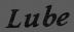

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


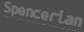

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


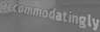

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


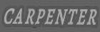

In [2]:
# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [3]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### 인코딩

In [4]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [5]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [6]:
# Encode한 후 Decode가 정상적으로 되는지 확인
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 모델 생성

In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 모델 학습

In [9]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [14]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
# ModelCheckPoint의 경우 'val_loss'를 모니터링하고 weight만 저장하는 옵션으로 지정해주세요.
# EarlyStopping도 'val_loss'를 모니터링해주세요.
# (EarlyStopping을 사용하지 않는 경우, model.fit()의 epoch 옵션을 20 정도로 설정해주세요.

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
)

EPOCHS = 20
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 85s 150ms/step - loss: 13.2812 - val_loss: 9.4174
Epoch 2/20
565/565 [==============================] - 86s 152ms/step - loss: 6.9115 - val_loss: 6.4968
Epoch 3/20
565/565 [==============================] - 87s 154ms/step - loss: 5.0526 - val_loss: 5.2251
Epoch 4/20
565/565 [==============================] - 87s 154ms/step - loss: 4.0306 - val_loss: 4.7557
Epoch 5/20
565/565 [==============================] - 86s 152ms/step - loss: 3.3241 - val_loss: 4.5633
Epoch 6/20
565/565 [==============================] - 87s 153ms/step - loss: 2.7668 - val_loss: 4.2549
Epoch 7/20
565/565 [==============================] - 86s 152ms/step - loss: 2.2988 - val_loss: 4.3562
Epoch 8/20
565/565 [==============================] - 86s 153ms/step - loss: 1.8941 - val_loss: 4.1463
Epoch 9/20
565/565 [==============================] - 87s 153ms/step - loss: 1.5538 - val_loss: 4.3371
Epoch 10/20
565/565 [==============================] - 85s 151ms/step - 

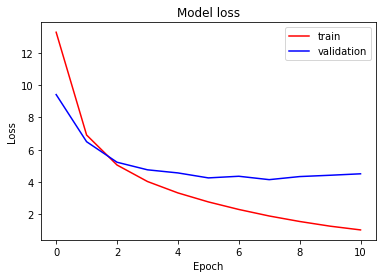

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

validation loss값이 이제까지 진행했던 프로젝트의 모델 loss값보다 좀 크다. focal loss가 값이 좀 큰 이유는 배웠던 거 같은데 얘는 왜 크지?

### 테스트

In [10]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [11]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5, chars = TARGET_CHARACTERS):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+chars)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

Result: 	 SLINKING9999999999999999


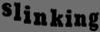

Result: 	 ALEPPO99999999999999999


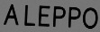

Result: 	 RWANDA999999999999999999


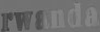

Result: 	 NATHANS99999999999999999


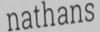

Result: 	 HALO99999999999999999999


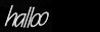

Result: 	 HURLS9999999999999999999


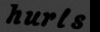

Result: 	 DOWNSIZE9999999999999999


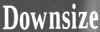

Result: 	 ROBOTIC99999999999999999


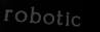

Result: 	 SLOPPY99999999999999999


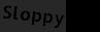

Result: 	 HERMITE99999999999999999


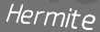

In [23]:
check_inference(model_pred, test_set, index=10)

대부분의 문자인식 추론 결과가 정확한 것 같다. 하지만 디코딩 후 결과에 9가 반복되어 나타나는 문제가 있어 TARGET_CHARACTERS에 BLANK를 추가함

In [12]:
BLANK = " "
DECODE_TARGET = TARGET_CHARACTERS + BLANK
print(f"The total number of characters is {len(DECODE_TARGET)}")

The total number of characters is 37


Result: 	 SLINKING                


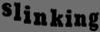

Result: 	 ALEPPO                 


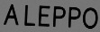

Result: 	 RWANDA                  


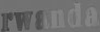

Result: 	 NATHANS                 


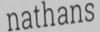

Result: 	 HALO                    


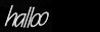

Result: 	 HURLS                   


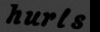

Result: 	 DOWNSIZE                


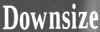

Result: 	 ROBOTIC                 


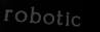

Result: 	 SLOPPY                 


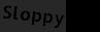

Result: 	 HERMITE                 


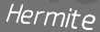

In [55]:
check_inference(model_pred, test_set, index=10, chars=DECODE_TARGET)

공백이 제대로 디코딩 되었음.

나는 처음부터 디코딩에만 공백을 추가해주었고 이걸 학습 단계에 추가해볼 생각은 못해봤는데<br>
태훈님이 TARGET_CHARACTERS에 공백을 추가해서 학습을 시키면 성능이 더 안 좋아진다고 알려주심.

텍스트 추론 이후 오른쪽에 나오는 공백은 결과에는 의미없는 문자이기 때문에 rstrip() 함수로 제거하면 됨(여기선 rstrip을 적용해주지 않았지만 아래 실험단계에서는 keras와 비교를 위해 적용함)

공백이 왜 9로 잘못 디코딩되었는지는 실험을 1,2개 수행한 후 알아볼 예정

## keras-ocr detector + CRNN recognizer

In [13]:
from keras_ocr.detection import Detector
import keras_ocr

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [14]:
from PIL import ImageDraw

def detect_text(img_path):
    # TODO

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img = keras_ocr.tools.read(img_path)
    img = np.expand_dims(img, axis=0)
    detection = detector.detect(img)

    # 배치의 첫 번째 결과만 가져옵니다.
    first = detection[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    #ocr_result = first[..., ::-1]
    ocr_result = first
    
    img_pil = Image.open(img_path).convert('RGB')  # PIL 이미지로 열기

    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        flat = keras_ocr.tools.flatten(text_result)
        img_draw.polygon(flat, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

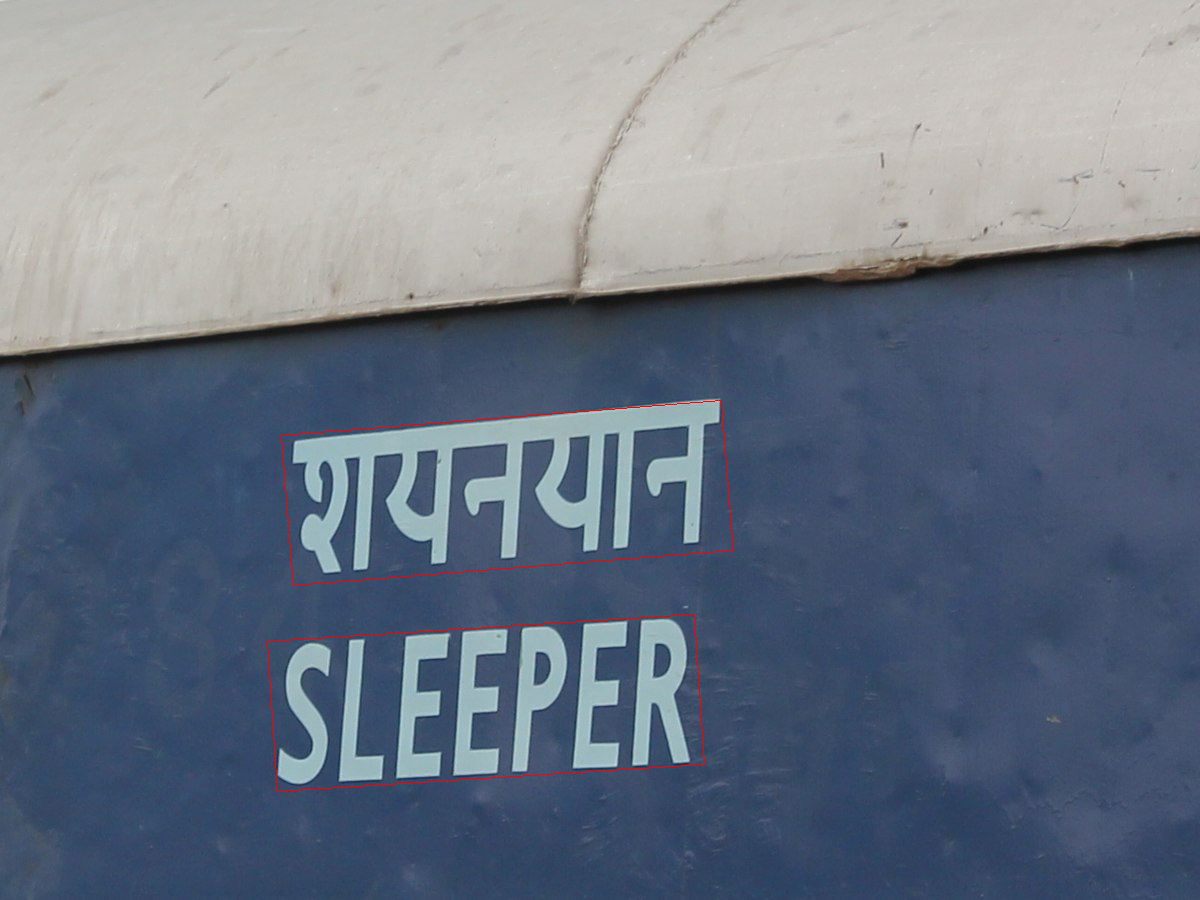

In [94]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [95]:
img = keras_ocr.tools.read(SAMPLE_IMG_PATH)
img = np.expand_dims(img, axis=0)
img

array([[[[213, 214, 209],
         [210, 211, 206],
         [206, 207, 202],
         ...,
         [187, 182, 178],
         [187, 182, 178],
         [190, 185, 181]],

        [[188, 189, 184],
         [187, 188, 183],
         [185, 186, 181],
         ...,
         [187, 182, 178],
         [186, 181, 177],
         [187, 182, 178]],

        [[175, 176, 171],
         [175, 176, 171],
         [176, 177, 172],
         ...,
         [188, 183, 179],
         [189, 184, 180],
         [192, 187, 183]],

        ...,

        [[ 60,  77, 103],
         [ 62,  79, 105],
         [ 63,  80, 106],
         ...,
         [ 56,  73, 101],
         [ 57,  74, 102],
         [ 57,  74, 102]],

        [[ 61,  78, 104],
         [ 62,  79, 105],
         [ 64,  81, 107],
         ...,
         [ 57,  74, 102],
         [ 58,  75, 103],
         [ 58,  75, 103]],

        [[ 60,  77, 103],
         [ 62,  79, 105],
         [ 64,  81, 107],
         ...,
         [ 57,  74, 102],
        

In [96]:
detection = detector.detect(img)
detection

[array([[[281.66437, 435.20853],
         [721.47235, 400.2238 ],
         [733.42975, 550.5454 ],
         [293.62177, 585.53015]],
 
        [[267.8013 , 641.50903],
         [694.89276, 614.62915],
         [704.3312 , 764.5946 ],
         [277.2397 , 791.4745 ]]], dtype=float32)]

내 코드에서는 x와 y좌표를 변경하지 않는 게 바운딩박스가 똑바로 그려진다. detection 결과값부터 y,x가 아닌 x,y로 나오는 것 같다.
keras_ocr.tools.read()가 이미지를 읽어 RGB 형식의 numpy 배열로 반환해준다고 해서 사용하였는데 여기서 (W,H,C)로 저장되어있던 것이 아닐까 추측

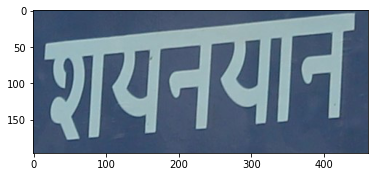

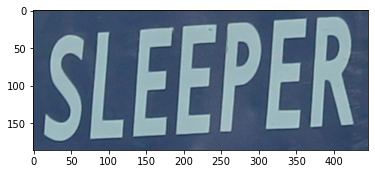

In [31]:
import matplotlib.pyplot as plt

plt.imshow(cropped_img[0])
plt.show()
plt.imshow(cropped_img[1])
plt.show()

In [15]:
def recognize_img(pil_img, input_img_size=(100,32), print_result=True):
    img = pil_img.resize((100, 32), 3)
    img = np.array(img).transpose(1, 0, 2)
    img = np.expand_dims(img, axis=0)
    
    output = model_pred.predict(img)
    result = decode_predict_ctc(output, chars="-" + DECODE_TARGET)[0].replace('-', '')
    if print_result:
        print(f"Result: \t", result)
        display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))
    
    return result

Result: 	 TEF                     


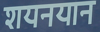

Result: 	 SLEEPER                


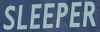

In [87]:
for _img in cropped_img:
    recognize_img(_img)

---

## 실험

#### 1. 하이퍼파라미터 변경

In [10]:
model2 = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01, clipnorm=5)
model2.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path = HOME_DIR + '/model2_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
)

EPOCHS = 20
history = model2.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 617s 985ms/step - loss: 27.2909 - val_loss: 26.8127
Epoch 2/20
565/565 [==============================] - 80s 141ms/step - loss: 25.5152 - val_loss: 25.3946
Epoch 3/20
565/565 [==============================] - 80s 142ms/step - loss: 25.0369 - val_loss: 25.0526
Epoch 4/20
565/565 [==============================] - 80s 141ms/step - loss: 24.6066 - val_loss: 24.5645
Epoch 5/20
565/565 [==============================] - 80s 141ms/step - loss: 24.1842 - val_loss: 24.2074
Epoch 6/20
565/565 [==============================] - 80s 141ms/step - loss: 23.7904 - val_loss: 24.0070
Epoch 7/20
565/565 [==============================] - 80s 141ms/step - loss: 23.4003 - val_loss: 23.8121
Epoch 8/20
565/565 [==============================] - 80s 141ms/step - loss: 23.0150 - val_loss: 23.0417
Epoch 9/20
565/565 [==============================] - 80s 141ms/step - loss: 22.6078 - val_loss: 22.6377
Epoch 10/20
565/565 [==============================] -

기존 learning rate이 0.1이어서 0.01로 변경해봄
- 20 epoch 정도 돌렸을 때 loss가 계속 감소하는 모습을 보임
- 0.1보다 loss가 줄어드는 속도는 현저히 느리지만 epoch 수를 조금 더 늘려서 돌려봐도 될 것 같음

In [11]:
model3 = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model3.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

checkpoint_path = HOME_DIR + '/model3_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
)

EPOCHS = 20
history = model3.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 81s 135ms/step - loss: 224.5904 - val_loss: 225.8678
Epoch 2/20
565/565 [==============================] - 76s 134ms/step - loss: 226.4163 - val_loss: 225.8678
Epoch 3/20
565/565 [==============================] - 76s 134ms/step - loss: 226.4164 - val_loss: 225.8678
Epoch 4/20
565/565 [==============================] - 76s 134ms/step - loss: 226.4164 - val_loss: 225.8678
Epoch 00004: early stopping


기존의 옵티마이저는 Adadelta여서 Adam으로 바꿔봄
- loss값이 226으로 매우 높음, Gradient Explosion 문제가 일어난 것 같음

#### 2. 다양한 폰트

In [16]:
from keras_ocr.recognition import Recognizer
import Levenshtein

# keras recognizer
recognizer = Recognizer()

Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [17]:
# keras recognizer를 사용했을 때와 crnn recognizer를 사용했을 때의 결과로 편집거리를 계산하여 성능 평가
def compare_(image_path):
    img_pil, cropped_img = detect_text(image_path)
    #display(img_pil)
    display(Image.fromarray(np.array(img_pil.resize((500, 500), 3)).astype(np.uint8)))
    
    avg = 0.0
    cnt = 0
    for _img in cropped_img:
        keras_result = recognizer.recognize(np.array(_img))
        crnn_result = recognize_img(_img, print_result=False).lower().rstrip()
        
        # 편집거리
        edit_dist = 1 - Levenshtein.distance(keras_result, crnn_result) / max(len(keras_result), len(crnn_result), 1)
        
        if cnt < 3:
            print(f"keras: {keras_result}, crnn: {crnn_result}")
        #print(edit_dist)
        
        avg += edit_dist
        cnt += 1
        
    avg /= len(cropped_img)
    return avg

새로운 이미지로 실험을 할 때마다 ground truth를 직접 넣어주기는 쉽지 않고 폰트에 따라 사람도 알아보기 쉽지 않을 때가 있어서 keras recognizer를 ground truth로 가정하고 비교를 하였다. <br>
keras recognizer가 100퍼센트의 정확하다고 할 수는 없지만 crnn recognizer보다는 좋을 것이기 때문에 상대적으로 성능을 평가하겠다.

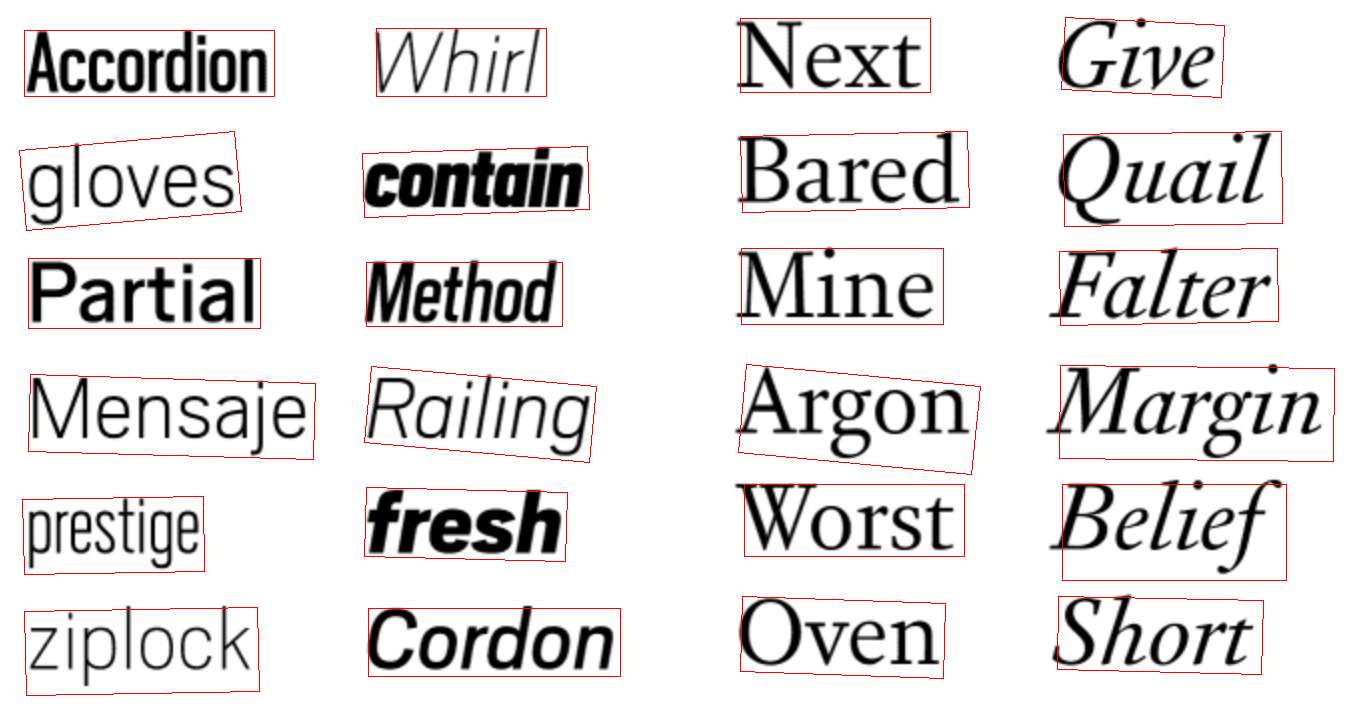

Result: 	 NEXT                    


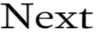

Result: 	 ZVE                     


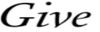

Result: 	 WHIR                    


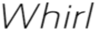

Result: 	 ACCORDION              


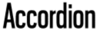

Result: 	 BARED                   


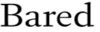

Result: 	 ULAIL                   


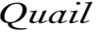

Result: 	 GLOVES                  


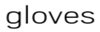

Result: 	 CONTAIN                 


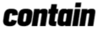

Result: 	 MINE                    


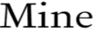

Result: 	 FALTER                  


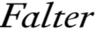

Result: 	 PARTIAL                 


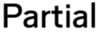

Result: 	 METHOD                  


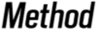

Result: 	 MARGIN                  


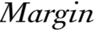

Result: 	 ARGON                   


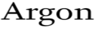

Result: 	 MENSAJE                 


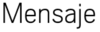

Result: 	 RAILING                 


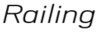

Result: 	 WORST                   


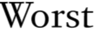

Result: 	 BELIEF                  


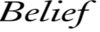

Result: 	 FRESH                   


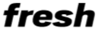

Result: 	 PRESTIGE                


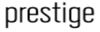

Result: 	 OVEN                    


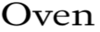

Result: 	 SHOT                    


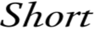

Result: 	 ZIPLOCK                 


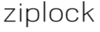

Result: 	 CORDON                  


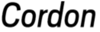

In [98]:
img_pil, cropped_img = detect_text(HOME_DIR + '/Images/test1.png')
display(img_pil)
for _img in cropped_img:
    recognize_img(_img)

In [118]:
compare_(HOME_DIR + '/Images/test1.png')

0.9458333333333333

[font1/font2](https://blog.rightbrain.co.kr/?p=1128)
[font3](https://luc.devroye.org/fonts-27426.html)
[font4](https://blog.rightbrain.co.kr/?p=1128)
[font5](https://portalnum.com/154)
[font6](https://noonnu.cc/en/posts/19269)
[font7](https://vineshop.tistory.com/6504)
[font8](https://www.behance.net/gallery/68343899/Borsok-font)
[font9](https://www.fgdesigners.com/2017/01/rimbo-free-font.html)
[font10](https://www.behance.net/gallery/76829783/STANLEY-FREE-ELEGANT-DISPLAY-TYPEFACE?tracking_source=search%7Cfree%20font)

In [22]:
import glob
import os

filenames = []
for i in range(1, 11):
    pattern = os.path.join(HOME_DIR, f"Images/font{i}.*")
    matches = glob.glob(pattern)
    filenames.extend(matches)

for file in filenames:
    print(file)

/aiffel/aiffel/ocr/Images/font1.png
/aiffel/aiffel/ocr/Images/font2.png
/aiffel/aiffel/ocr/Images/font3.png
/aiffel/aiffel/ocr/Images/font4.jpg
/aiffel/aiffel/ocr/Images/font5.png
/aiffel/aiffel/ocr/Images/font6.jpeg
/aiffel/aiffel/ocr/Images/font7.png
/aiffel/aiffel/ocr/Images/font8.png
/aiffel/aiffel/ocr/Images/font9.jpeg
/aiffel/aiffel/ocr/Images/font10.png


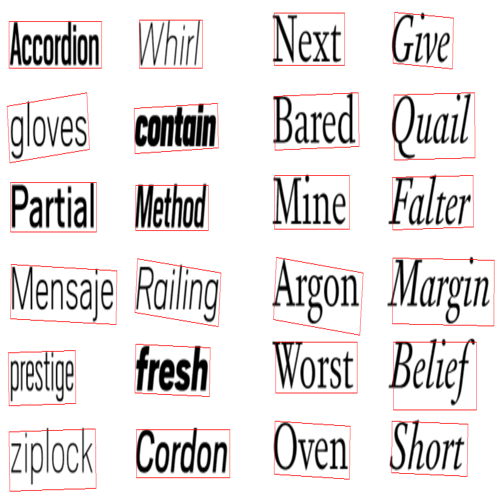

keras: next, crnn: next
keras: give, crnn: zve
keras: whirl, crnn: whir
0.9458333333333333


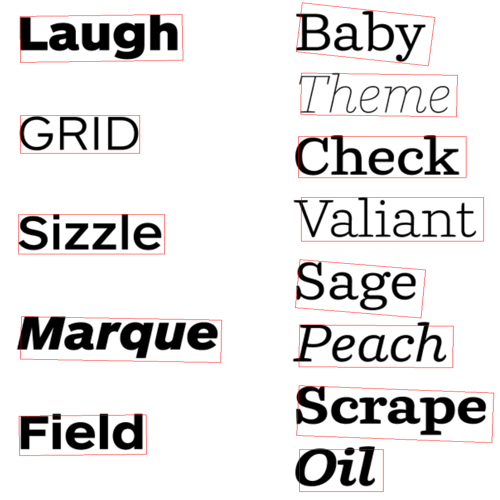

keras: baby, crnn: baby
keras: laugh, crnn: laugh
keras: theme, crnn: theme
0.9435897435897436


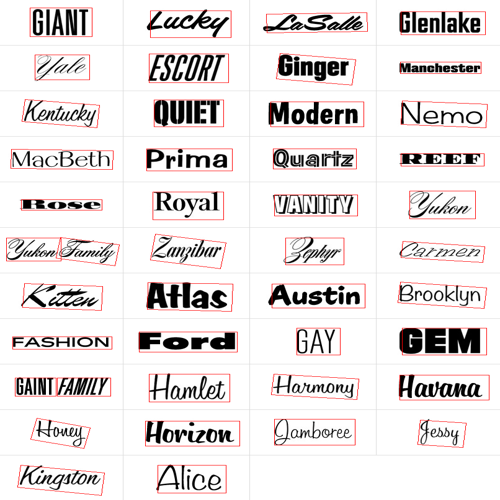

keras: giant, crnn: glant
keras: lucky, crnn: leuc
keras: glenlake, crnn: glenlake
0.6531918208054572


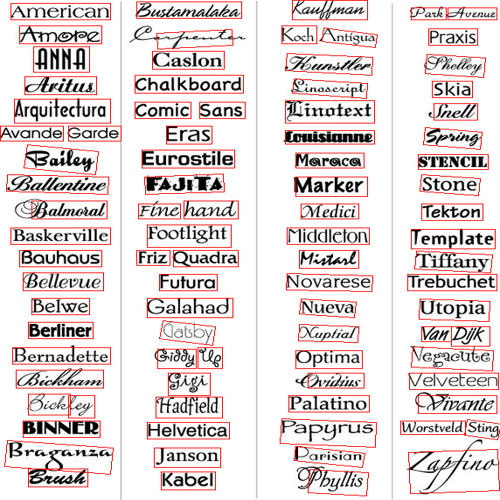

keras: kanlman, crnn: karulpman
keras: bustamala, crnn: butanatats
keras: american, crnn: american
0.7291429544238534


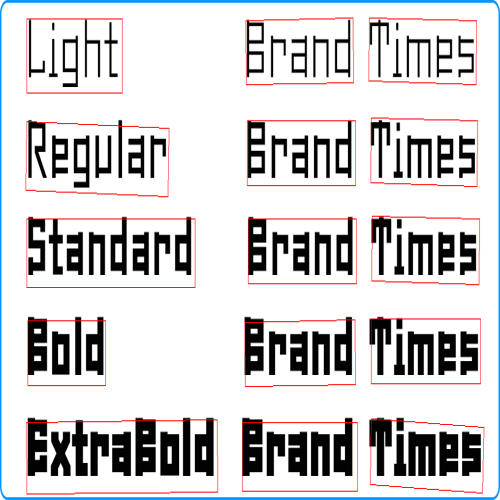

keras: light, crnn: light
keras: brand, crnn: arand
keras: times, crnn: titas
0.812804232804233


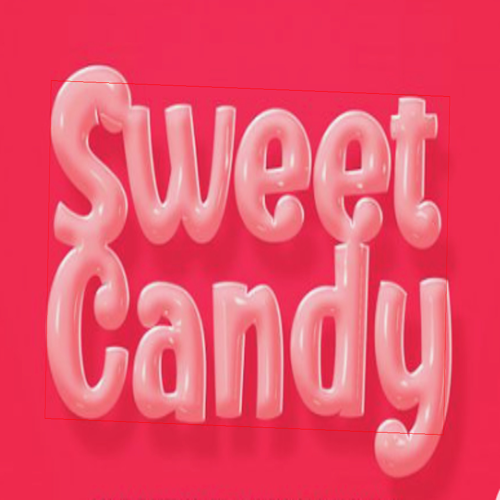

keras: candy, crnn: teates
0.16666666666666663


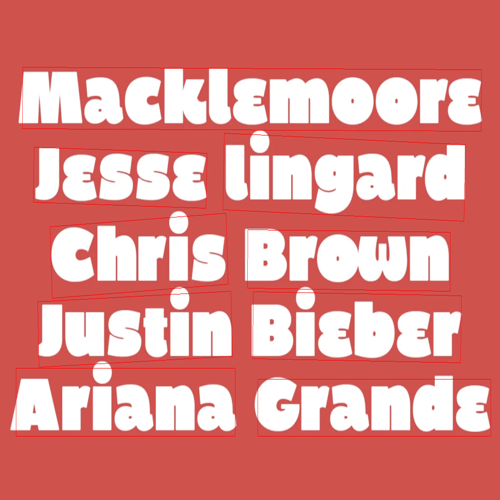

keras: macklemoore, crnn: actitoat
keras: lingard, crnn: ringards
keras: jesse, crnn: licriets
0.41535594035594037


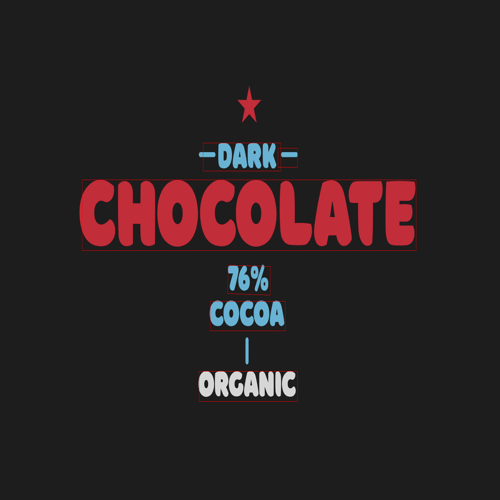

keras: tdarks, crnn: poarks
keras: s, crnn: uss
keras: chocolate, crnn: teaghilises
0.48268398268398266


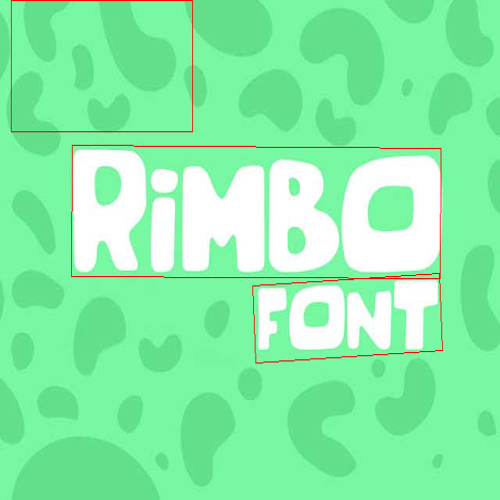

keras: daos, crnn: rotes
keras: rimbo, crnn: rimber
keras: font, crnn: eiyh
0.2888888888888889


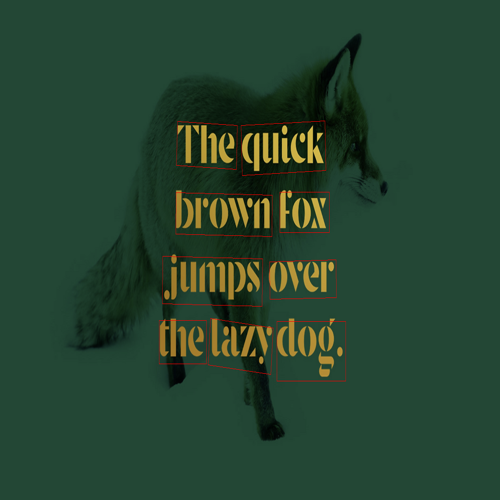

keras: quick, crnn: cfurick
keras: the, crnn: es
keras: fox, crnn: fem
0.27089947089947086

edit dist : 0.570905703445157


In [23]:
final_avg = 0
for file in filenames:
    result = compare_(file)
    print(result)
    final_avg += result
    
final_avg /= len(filenames)
print()
print("==============================")
print(f"edit dist : {final_avg}")

keras recognizer의 성능은 대체로 결과가 좋았고 그에 비해 crnn recognizer는 57프로의 성능을 보였다. 다양한 폰트에 대해서 학습이 필요해 보인다.

#### 3. 글자 방향

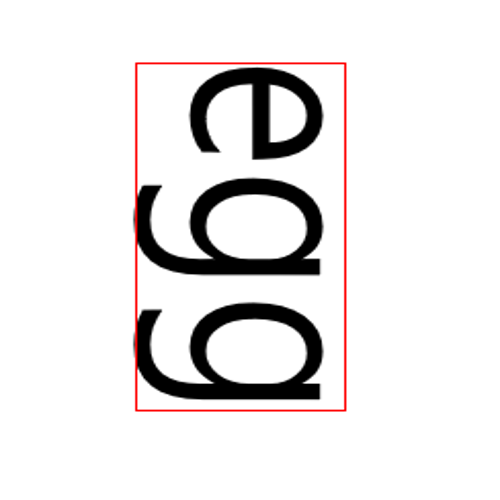

keras: 8, crnn: fres
0.0


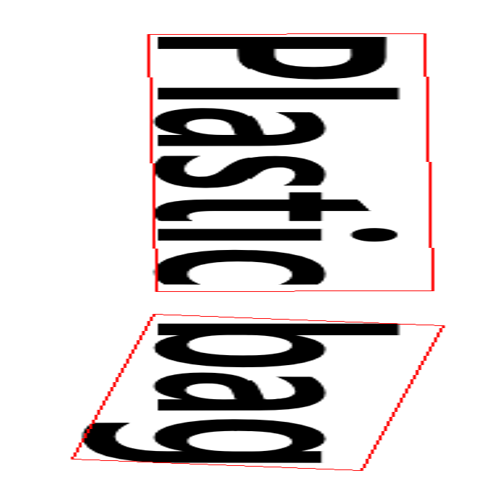

keras: e, crnn: saa
keras: g, crnn: htr
0.0


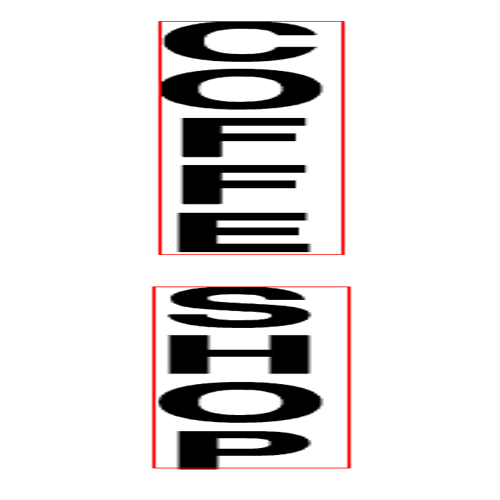

keras: e, crnn: iast
keras: s, crnn: azn
0.0

edit dist : 0.0


In [21]:
import glob
import os

filenames = []
for i in range(1, 4):
    pattern = os.path.join(HOME_DIR, f"Images/direct{i}.*")
    matches = glob.glob(pattern)
    filenames.extend(matches)

final_avg = 0
for file in filenames:
    result = compare_(file)
    print(result)
    final_avg += result
    
final_avg /= len(filenames)
print()
print("==============================")
print(f"edit dist : {final_avg}")

폰트에 대한 성능이 좋지 않음을 확인하였기에 방향에 대한 실험은 기본 글꼴로 진행하였음.

세로쓰기로 방향이 달라진 글자는 keras recognizer, crnn recognizer 모두 성능이 좋지 않은 걸 확인할 수 있었다.

#### 4. 디자인 포스터

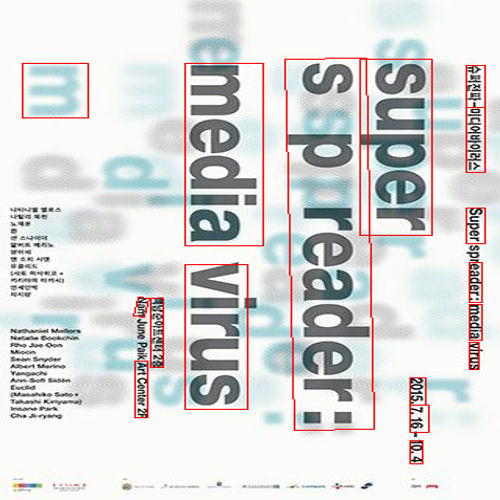

keras: , crnn: rsses
keras: s, crnn: aatst
keras: i, crnn: wesiun
0.16666666666666666


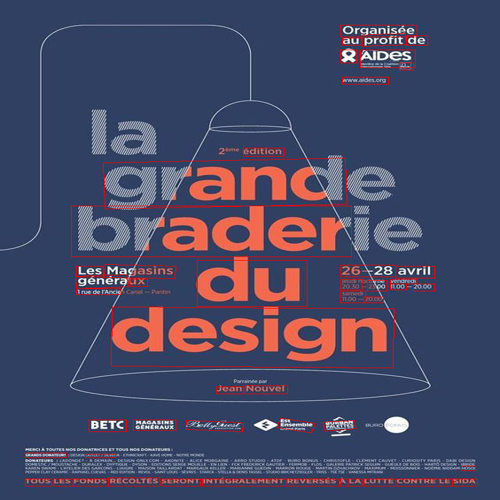

keras: organisee, crnn: organiste
keras: tprofit, crnn: profty
keras: ede, crnn: sls
0.39515048443619866


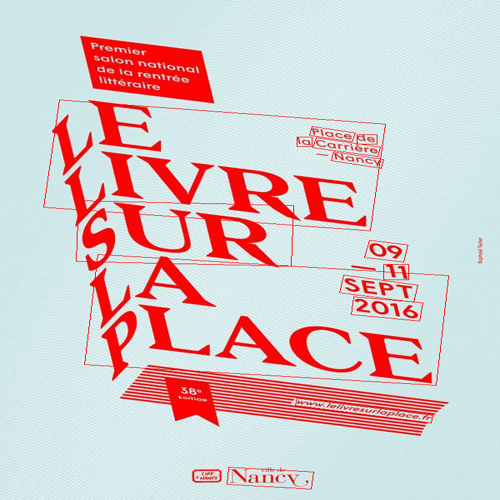

keras: premier, crnn: pretepesess
keras: salo, crnn: prepsunisetess
keras: rational, crnn: rbospntiss
0.17140151515151514


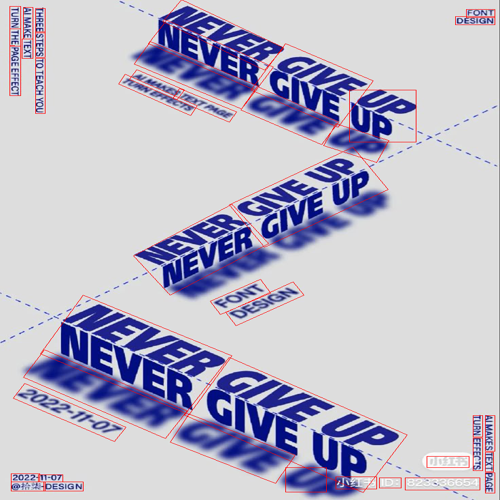

keras: s, crnn: mesns
keras: , crnn: ashmats
keras: s, crnn: aes
0.2177464008859358

edit dist : 0.23774126678507906


In [25]:
filenames = []
for i in range(1, 5):
    pattern = os.path.join(HOME_DIR, f"Images/test{i}.*")
    matches = glob.glob(pattern)
    filenames.extend(matches)

final_avg = 0
for file in filenames:
    result = compare_(file)
    print(result)
    final_avg += result
    
final_avg /= len(filenames)
print()
print("==============================")
print(f"edit dist : {final_avg}")

[test1](https://kr.pinterest.com/pin/12947917674753184/)
[test2](https://kr.pinterest.com/pin/7881368092505765/)
[test3](https://kr.pinterest.com/pin/492649952227739/)
[test4](https://kr.pinterest.com/pin/1055599908001755/)

인터넷 서치 하다가 나온 디자인 포스터 중에 궁금한 것들을 실험해봄.

예상대로 keras recognizer, crnn recognizer 모두 성능이 좋지 않음.

#### 5. 공백이 9로 디코딩 된 이유

In [ ]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# inference 전용 모델
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [22]:
def max_idx(output):
    max_list = []
    for o in output:
        m = np.argmax(o)
        max_list.append(m) 
    print(max_list)
    return max_list

[[[1.96873953e-04 5.85230555e-06 2.50951530e-07 1.01099971e-07
   2.72109961e-08 2.13130875e-06 1.66307041e-06 2.96402823e-06
   4.44673773e-08 9.84508642e-06 7.97752080e-07 2.41939324e-06
   3.17567412e-08 1.05006684e-07 1.90009769e-06 7.64611571e-07
   2.05113480e-07 5.11319769e-08 5.44278873e-06 4.82467767e-05
   1.80372197e-07 9.97258121e-06 2.75039213e-07 4.53138341e-07
   7.17326373e-07 1.30362594e-06 9.30520585e-08 1.34074213e-07
   3.67549603e-07 9.17213185e-08 8.65775746e-07 4.61720219e-07
   2.83958730e-06 7.47589183e-07 1.21170103e-07 2.12011940e-07
   1.58256398e-07 9.99701202e-01]
  [5.47586715e-05 1.41633409e-05 1.31531817e-06 2.61597592e-07
   9.65389049e-08 2.40956069e-06 1.12956086e-05 4.06532745e-05
   5.03490071e-07 1.09580124e-05 6.14457849e-06 2.81136136e-06
   2.67417750e-08 1.20970162e-06 1.13461829e-06 1.83801518e-07
   2.74970176e-07 2.84574753e-07 3.59437138e-07 1.54509038e-01
   6.96773782e-07 6.07466609e-06 9.74521654e-08 6.49909452e-07
   4.99946509e-07 2.2

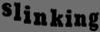

In [23]:
def check_inference2(model, dataset, index = 5, chars = TARGET_CHARACTERS):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        print(output)
        max_idx(output[0])
        result = decode_predict_ctc(output, chars="-"+chars)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
        
check_inference2(model_pred, test_set, index=1)

TARGET_CHARACTERS의 수는 36이고 학습 단계에는 문자 간 경계를 나타내는 '-' 토큰도 들어가지 않음.<br>
하지만 모델의 추론 결과는 38개를 가지고 있음.<br>
디코딩에는 '-' 토큰이 추가되고 37개. 그럼 남은 하나는 ' '으로 유추할 수 있음.

1차원 리스트(한 행?)의 각 원소는 TARGET_CHARACTERS의 각 문자에 해당하는 확률이라고 생각해서 max값이 들어있는 원소의 인덱스값을 출력해 보았는데 규칙을 찾을 수 없었다. 이 문제에 대한 해답을 확실히 알려면 decode_predict_ctc() 함수의 K.get_value와 K.ctc_decode에 대해서 자세히 이해해야 할 것 같은데 이 부분까지는 하지 못하였다.

GPT 답변
- 모델이 BLANK를 예측하더라도 디코더는 그 클래스가 무슨 의미인지 모름
- 결과적으로 BLANK index 위치에 있는 클래스가 잘못 매핑됨
- 예를 들어 실제로는 BLANK였던 위치가 문자 '9'로 매핑됨 → '9999'처럼 반복된 결과

---

#### 회고
- 모델 학습 시간도 짧고 주말도 있어서 여러 실험을 해볼 수 있었던 것 같다.
- 기계 학습이 잘 진행됐는지 판단하기 위해 여러 optimization으로 비교도 해보고 다양한 테스트셋에 대해 성능도 확인해보려 하였다. 아직 많이 부족하지만 하루하루 늘고 있는 것 같다. 성능이 안 좋았던 다양한 폰트, 다양한 각도에 대한 데이터셋도 추가하여 학습시켜 봤으면 더 좋았을 것 같다.
- 왜 epoch 수는 20인지, 왜 여기선 이 옵티마이저를 썼는지 등 다른 사람이 이렇게 하면 좋더라 하는 것을 내 것으로 만들기 위해 의심하고 분석해 보는 습관을 들이도록 노력해야겠다.